In [1]:
import numpy as np
import matplotlib.pyplot as plt

from timeit import default_timer as timer

# This attempts to re-compile the library in case it has been changed, mostly for debug, but won't do anything
# if nothing is changed
import subprocess
out = subprocess.run(["python", "setup.py", "build_ext", "--inplace"], stdout=subprocess.PIPE)
import gropt

from helper_utils import *

%matplotlib inline

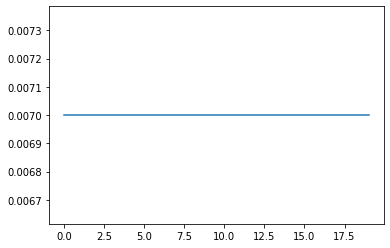

In [2]:
dt = 10e-6

g_ss = .0070
N_ss = int(np.round(1.375/(g_ss*dt)*1e-6))
G_ss = np.ones(N_ss) * g_ss

plt.figure()
plt.plot(G_ss)

In [3]:
params = {}
params['mode'] = 'free'
params['gmax']  = 0.05
params['smax']  = 100.0

params['moment_params']  = [[0, 0, 0, -1, -1, 0.0, 1.0e-3]]
params['moment_params'].append([0, 1, 0, -1, -1, 0.0, 1.0e-3])
params['dt']  = dt

TE = 1.0e-3
N = int(np.round(TE/dt))
gfix = np.ones(N) * -999999
gfix[0] = 0.0
gfix[-1] = 0.0
gfix[:N_ss] = G_ss

params['gfix']  = gfix

G, dd = gropt.gropt(params, verbose=1)
plot_waveform(G, params)

ERROR: params does not contain key "TE"


TypeError: cannot unpack non-iterable NoneType object

Fixed region of waveform = 0.210000 ms
Testing TE = 1.11  ** 112 112 112 **
Good TE = 1.11
 0.67  ** 67 67 67 **
 0.89  ** 89 89 89 **
 1.00  ** 100 100 100 **
Good TE = 0.99875
 0.94  ** 95 95 95 **
Good TE = 0.943125
 0.92  ** 92 92 92 **
Good TE = 0.9153125
 0.90  ** 91 91 91 **
Good TE = 0.90140625
 0.89  ** 90 90 90 **
Good TE = 0.8944531250000001
 0.89  ** 90 90 90 **
Good TE = 0.8909765625000001
 0.89  ** 89 89 89 **
 Final TE = 0.891 ms


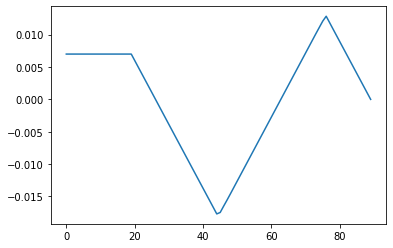

In [5]:
T_hi = 2.0
verbose = 1

dt = params['dt']

gfix_init = params['gfix'].copy()
free_vals = (gfix_init<-9999).astype(np.int)
dd = np.diff(free_vals)
block_check = np.abs(dd).sum()
if block_check > 2:
    print('ERROR: Found more than one consecutive free block in gfix, TE finder not supported yet')

N_free = int(free_vals.sum())
N_fix = free_vals.size - N_free
T_fix = N_fix * dt
print('Fixed region of waveform = %f ms' % (T_fix*1e3,))
block_start = np.where(dd==1)[0][0] + 1
block_stop = np.where(dd==-1)[0][0]

gfix_p0 = gfix_init[:block_start]
gfix_p2 = gfix_init[block_stop+1:]

T_lo = (N_fix+1) * dt * 1e3;
T_range = T_hi-T_lo;


best_time = 999999.9

if verbose:
    print('Testing TE =', end='', flush=True)
while ((T_range*1e-3) > (dt/4.0)): 
    TE = T_lo + (T_range)/2.0
    if verbose:
        print(' %.2f' % TE, end='', flush=True)
   
    params['TE'] = TE
    NN = int(TE*1e-3/dt) + 1
    
    gfix_TE = np.hstack([gfix_p0, np.ones(NN-N_fix)*-99999, gfix_p2])
    
    params['gfix'] = gfix_TE.copy()
    
    G, ddebug = gropt.gropt(params)
    print('  **', NN, gfix_TE.size, G.size, '**')
    lim_break = ddebug[14]
    if lim_break == 0:
        T_hi = params['TE']
        if T_hi < best_time:
            print('Good TE =', T_hi)
            G_out = G
            T_out = T_hi
            best_time = T_hi
            good_gfix = gfix_TE.copy()
    else:
        T_lo = params['TE']
    T_range = T_hi-T_lo

if verbose:
    print(' Final TE = %.3f ms' % T_out)

plt.figure()
plt.plot(G_out)


In [ ]:
NN = 100
gfix_TE = np.hstack([gfix_p0, np.ones(NN-N_fix)*-99999, gfix_p2])

In [ ]:
TE = T_out
print(TE*1e-3/dt)
NN = int(np.round(TE*1e-3/dt))
print(NN)

In [ ]:
params['TE'] = T_out
params['gfix'] = good_gfix
GG, dd = gropt.gropt(params, verbose = 1)
plt.figure()
plt.plot(GG)
print(GG.size, good_gfix.size)

In [ ]:
good_gfix